### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SBSBBSSB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12655
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    124.1| 46.2667|-119.1167|       TMAX|USW00024163|    36|[00 7E 00 7E 00 7...|1998.0|SBSBBSSB|
|    124.1| 46.2667|-119.1167|       TMAX|USW00024163|     1|[80 54 30 54 40 C...|1999.0|SBSBBSSB|
|    124.1| 46.2667|-119.1167|       TMAX|USW00024163|     3|[30 55 E0 55 80 5...|2000.0|SBSBBSSB|
|    124.1| 46.2667|-119.1167|       TMAX|USW00024163|     3|[20 50 80 51 00 4...|2001.0|SBSBBSSB|
|    124.1| 46.2667|-119.1167|       TMAX|USW00024163|     1|[E0 50 80 51 30 5...|2002.0|SBSBBSSB|
+---------+--------+---------+-----------+-----------+------+-------------

### Select data for a particular station and measurement type

In [2]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USW00024163')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='PRCP' and station='USW00024163'
14 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    124.1| 46.2667|-119.1167|       PRCP|USW00024163|     0|[00 00 00 00 00 0...|1999.0|SBSBBSSB|
|    124.1| 46.2667|-119.1167|       PRCP|USW00024163|     3|[00 00 00 00 60 5...|2000.0|SBSBBSSB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(14, 365)

### Script for plotting yearly plots

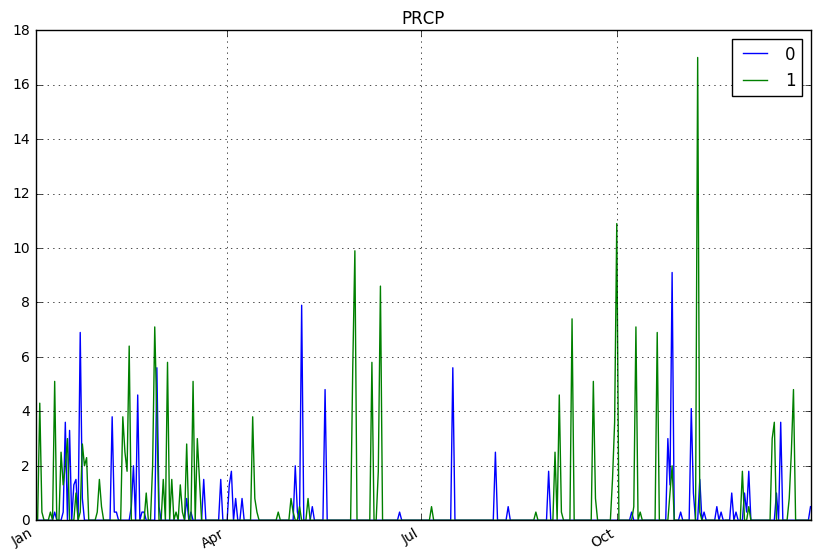

In [3]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [4]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

//anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


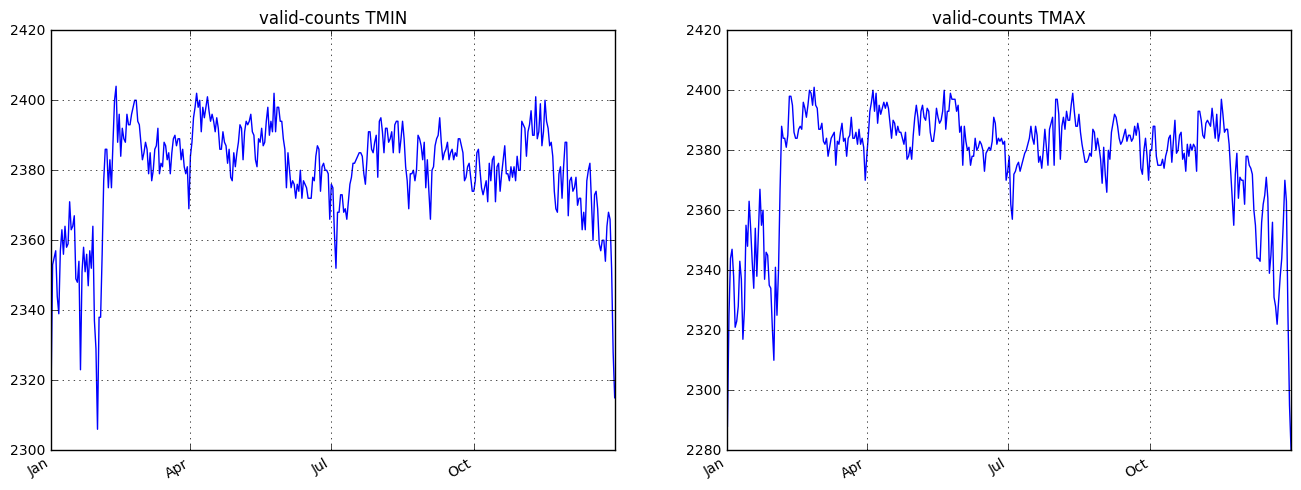

In [5]:
plot_pair(['TMIN','TMAX'],plot_valid)

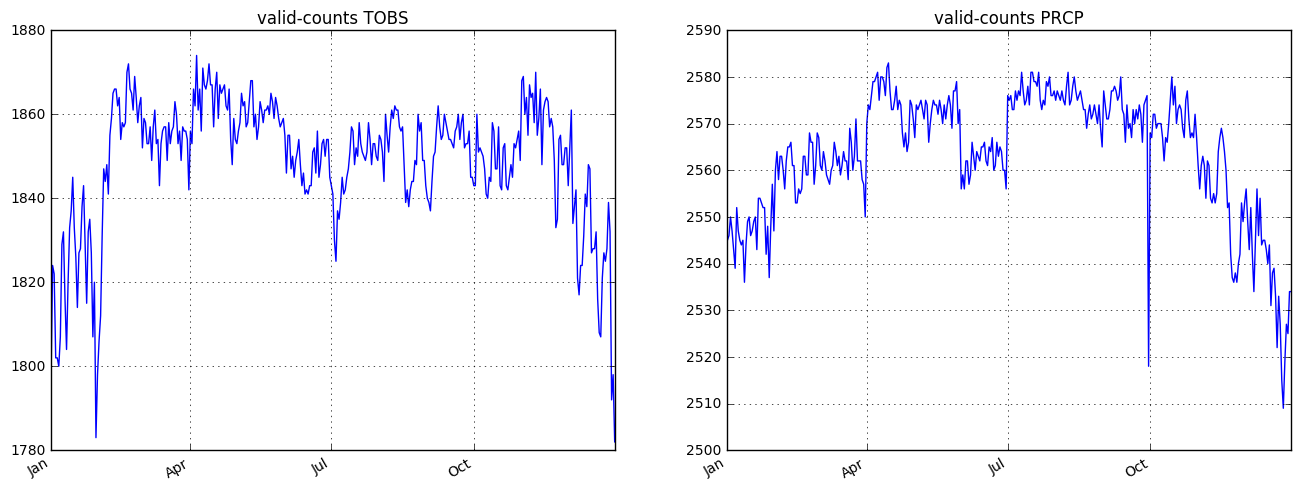

In [6]:
plot_pair(['TOBS','PRCP'],plot_valid)

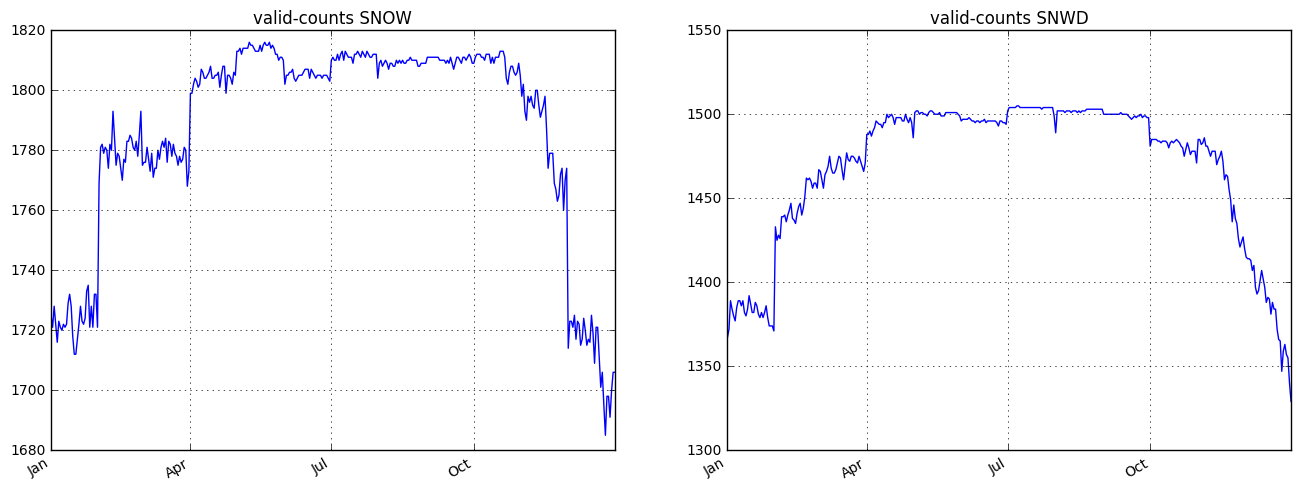

In [7]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [9]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    if m=='TMIN'or m=='TMAX'or m=='TOBS':
        mean /= 10
        std /= 10
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

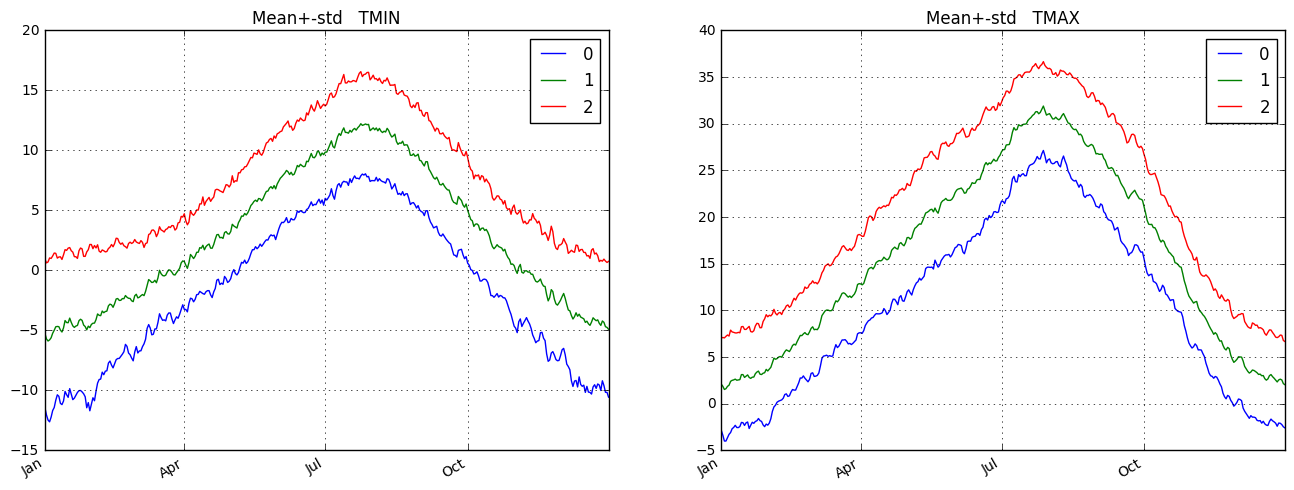

In [10]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

In [14]:
print STAT['TMIN']['Mean']

[ -5.26590419e+00  -5.72324692e+00  -5.89634820e+00  -5.80250318e+00
  -5.62657850e+00  -5.25053442e+00  -5.00059398e+00  -4.70922556e+00
  -4.68264007e+00  -4.70080372e+00  -4.98545377e+00  -5.14671471e+00
  -4.80725432e+00  -4.19195937e+00  -4.35655668e+00  -4.37317279e+00
  -3.98803746e+00  -4.34378194e+00  -4.63504673e+00  -4.76074042e+00
  -4.64955338e+00  -4.59800679e+00  -4.20093577e+00  -4.08234295e+00
  -4.17763102e+00  -4.56767077e+00  -4.69277211e+00  -4.96590525e+00
  -4.65836543e+00  -4.78063547e+00  -4.51500434e+00  -4.41274594e+00
  -4.40594525e+00  -4.11150255e+00  -3.64131258e+00  -3.75452640e+00
  -3.78457670e+00  -3.39932632e+00  -3.53898447e+00  -3.43924211e+00
  -3.40791457e+00  -2.96533333e+00  -2.82445923e+00  -2.87977387e+00
  -3.08835559e+00  -2.78544463e+00  -2.39067726e+00  -2.35625785e+00
  -2.51436348e+00  -2.50484140e+00  -2.35946511e+00  -2.37141663e+00
  -2.10705342e+00  -2.24966639e+00  -2.33491667e+00  -2.34929167e+00
  -2.54423559e+00  -2.61604680e+00

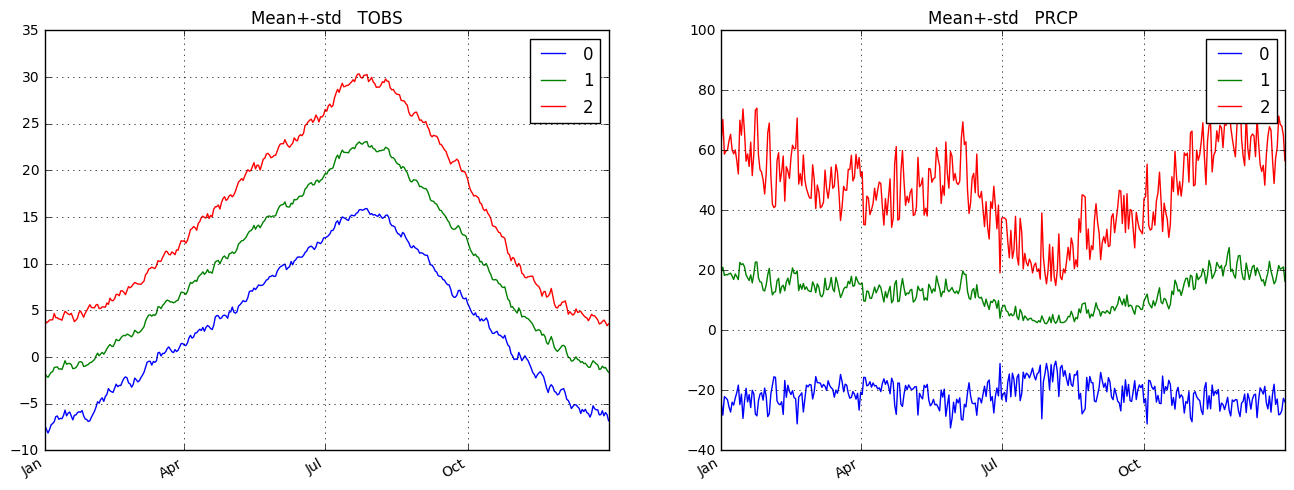

In [11]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

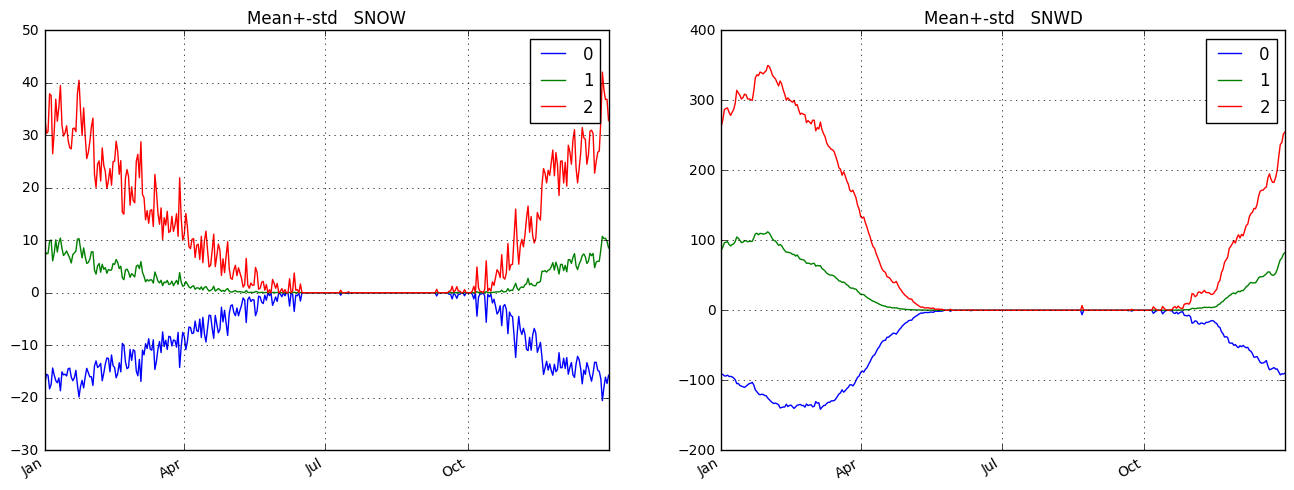

In [12]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [12]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

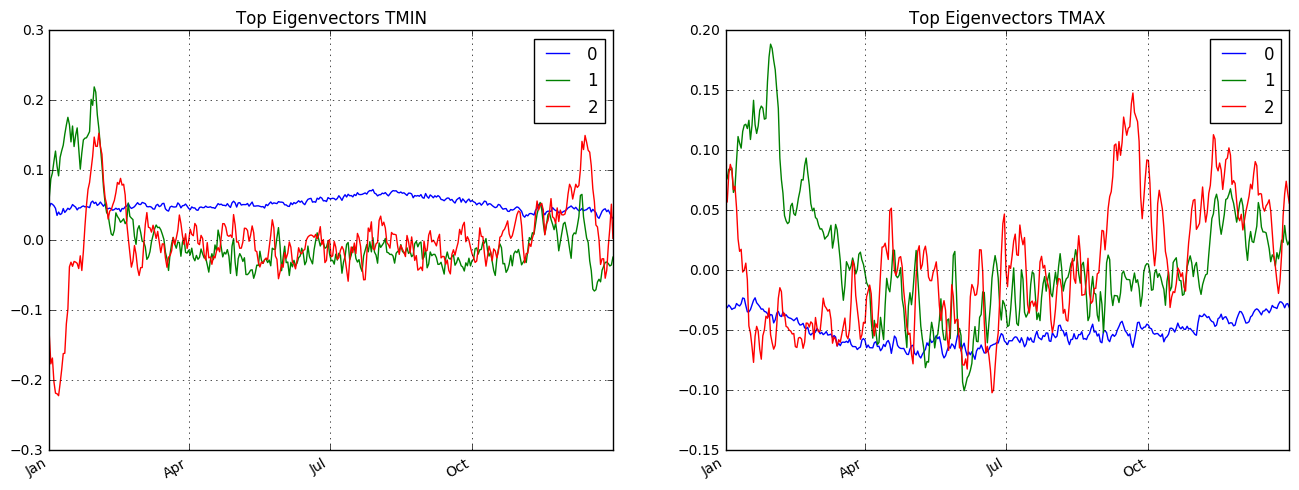

In [13]:
plot_pair(['TMIN','TMAX'],plot_eigen)

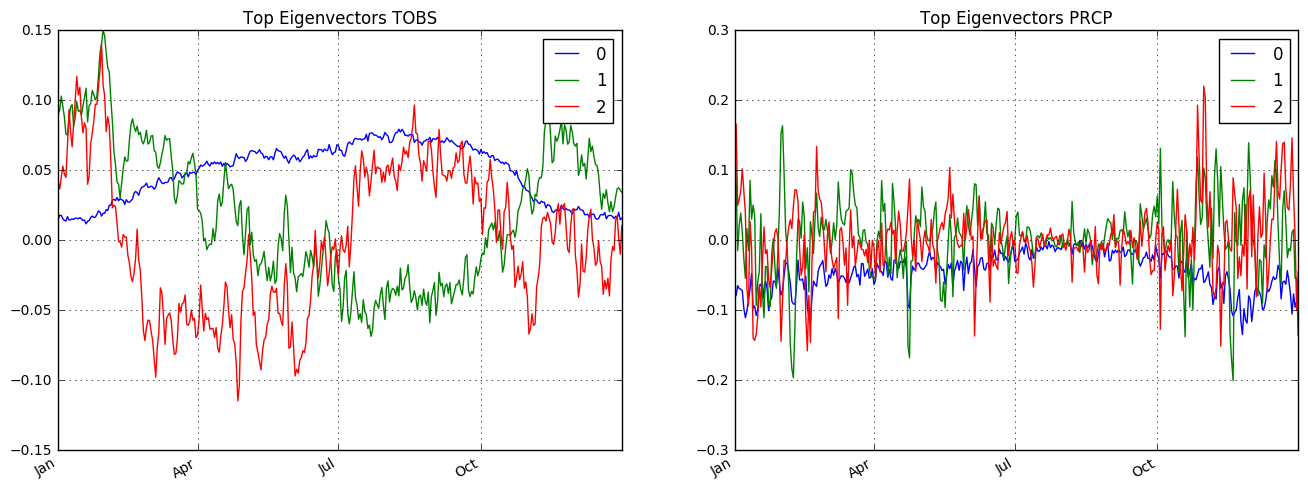

In [14]:
plot_pair(['TOBS','PRCP'],plot_eigen)

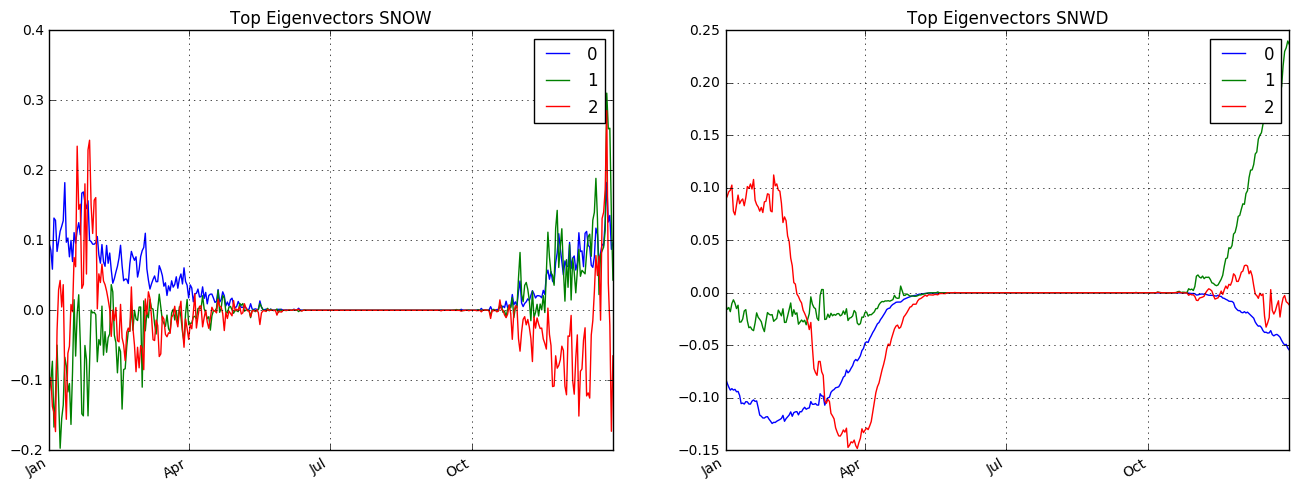

In [15]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [15]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    print ([0,]+list(cumsum(EV[:k])))/sum(EV)
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

[ 0.          0.18043756  0.22852313  0.26376843  0.29614465  0.32469445]
[ 0.          0.43685812  0.46957417  0.48958281  0.5088895   0.52418819]
[ 0.          0.20747044  0.24360752  0.2750586   0.29934043  0.32274279]


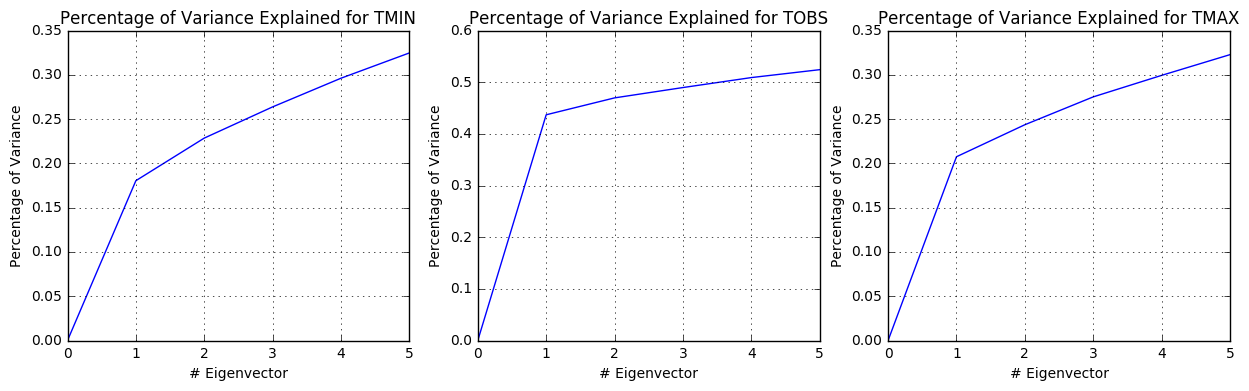

In [16]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

[ 0.          0.07999639  0.11282015  0.13866919  0.16195545  0.18370739]
[ 0.          0.79670252  0.85946942  0.90166077  0.9186293   0.93010862]
[ 0.          0.06091911  0.0795316   0.09684577  0.11268975  0.12766642]


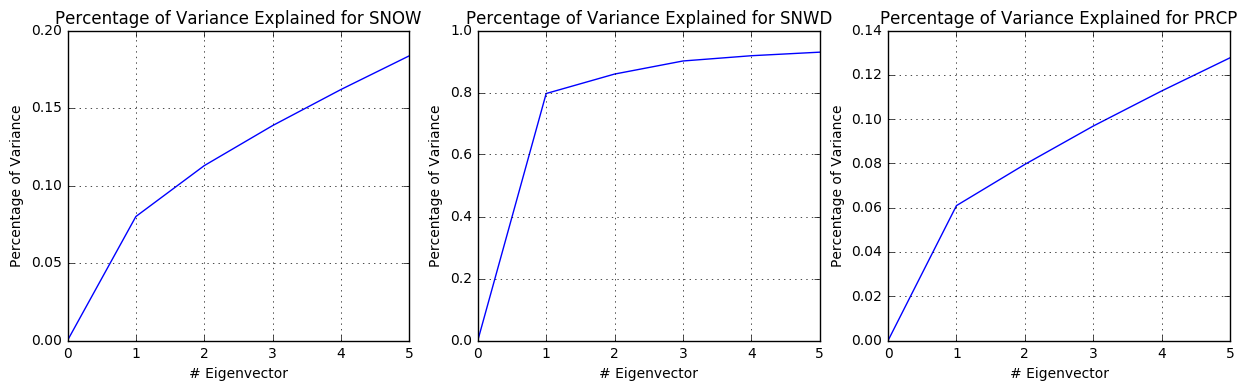

In [17]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [19]:
#sc.stop()